In [7]:

from torch.utils.data import DataLoader
from generators.subseries_converter import EchoStateDataset
from models.vanila_mlm_transformer import TransformerMLMModel
from generators.brownian_motion_generator import BrownianMotionDataset
from generators.poisson_process_generator import PoissonProcessDataset
from models.vanilla_transformer import TransformerModel
from probes.linear_probe import LinearProbe
import matplotlib.pyplot as plt


checkpoint_path = "/home/wojciech/private/magisterka/TFTS/training/magisterka/tuhc1b9i/checkpoints/transformer-epoch=05-val_loss=0.08.ckpt"

# Load the trained model
model = TransformerMLMModel.load_from_checkpoint(checkpoint_path)
model.to('cuda')

n_input = 1
n_reservoir = 50
spectral_radius = 0.9
sparsity = 0.1
input_scaling = 0.1
leak_rate = 0.2
device = "cuda"
train_len = 10_000
val_len = 1_000
lr = 1e-4

ESN_id = 40

# Create dataset and dataloaders
batch_size = 1
series_length = 1000
tile_size = 50
stride = 50
padding = 0

val_dataset = EchoStateDataset(
        num_series=val_len,
        series_length=series_length,
        tile_size=tile_size,
        stride=stride,
        padding=padding,
        n_input=n_input,
        n_reservoir=n_reservoir,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        input_scaling=input_scaling,
        leak_rate=leak_rate,
        device=device,
        esn_id=ESN_id,
        initial_seed=0,
        non_repeat = False
    )

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

/home/wojciech/anaconda3/envs/TFTS/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
x, y = next(iter(val_loader))

In [10]:
predictions = []
for i in range(x.shape[1]):
    new_x = x.detach().clone()
    new_x[:, i, :] = 0
    new_x = new_x.to('cuda')
    x_dash = model(new_x)
    predictions.append(x_dash[:, i, :])

In [12]:
import torch
predictions = torch.stack(predictions, dim=1)

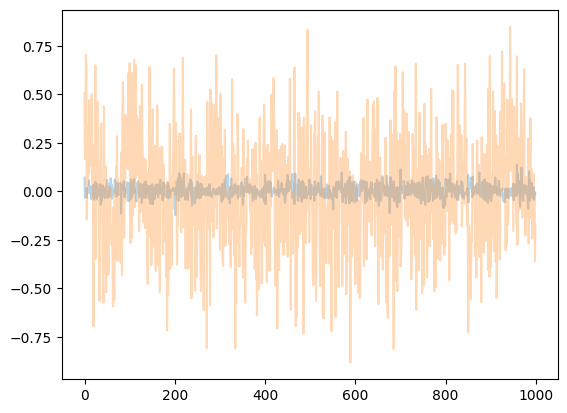

In [20]:
plt.plot(predictions.detach().cpu().numpy().flatten(), alpha=0.3)
plt.plot(x.detach().cpu().numpy().flatten(), alpha=0.3)

In [25]:
from sklearn.metrics import r2_score

r2_score(predictions.cpu().detach().numpy().flatten(), x.cpu().detach().numpy().flatten())

-72.31412506103516

(array([ 2.,  0.,  1.,  2.,  0.,  1.,  0.,  2.,  0.,  1.,  2.,  1.,  6.,
         1.,  1.,  6.,  5.,  6.,  4.,  2.,  8.,  4.,  8.,  7.,  6., 13.,
        10.,  8.,  9.,  9., 13., 14., 13., 17., 14., 15., 23., 21., 20.,
        27., 18., 20., 25., 17., 27., 23., 24., 19., 26., 22., 20., 30.,
        34., 21., 20., 19., 20., 21., 20., 22., 16., 22., 13., 14., 20.,
         7., 12., 12., 11.,  9., 10., 10., 10., 11.,  6.,  6.,  9.,  4.,
         3.,  6.,  5.,  2.,  6.,  2.,  2.,  3.,  3.,  5.,  2.,  2.,  3.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-0.8658396 , -0.84856701, -0.83129436, -0.81402177, -0.79674911,
        -0.77947652, -0.76220387, -0.74493128, -0.72765863, -0.71038604,
        -0.69311339, -0.6758408 , -0.65856814, -0.64129555, -0.6240229 ,
        -0.60675031, -0.58947766, -0.57220507, -0.55493242, -0.53765982,
        -0.52038717, -0.50311458, -0.48584196, -0.46856934, -0.45129672,
        -0.4340241 , -0.41675147, -0.39947885, -0.38220623, -0.364933

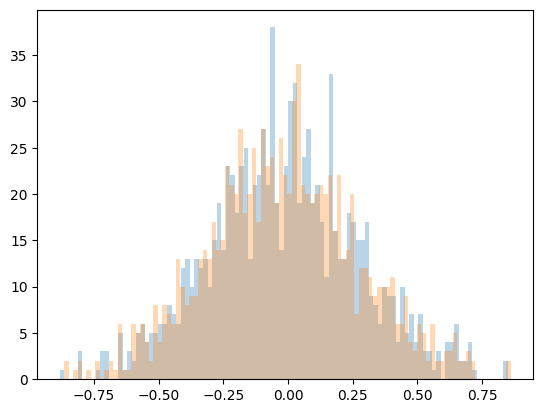

In [23]:
plt.hist(x.detach().cpu().numpy().flatten(), alpha=0.3, bins=100)
plt.hist((x-predictions.cpu()).detach().numpy().flatten(), alpha=0.3, bins=100)